# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Generating-random-data" data-toc-modified-id="Generating-random-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Generating random data</a></div><div class="lev1 toc-item"><a href="#Applying-a-Welch-t-test-to-the-data" data-toc-modified-id="Applying-a-Welch-t-test-to-the-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Applying a Welch t-test to the data</a></div><div class="lev1 toc-item"><a href="#The-Parametric-Bootstrap" data-toc-modified-id="The-Parametric-Bootstrap-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>The Parametric Bootstrap</a></div>

Welcome to our primer on [Parametric Bootstrapping](https://arxiv.org/pdf/1301.2936.pdf). 

Before we start, we must load a few libraries.
`pandas` for Dataframe handling
`numpy` for useful numeric functions
`scipy` for statistical testing
`matplotlib` and `seaborn` for graphics.

After we have loaded everything, I will set up my configurations to make sure that everything is aesthetically pleasing.

In [1]:
import pandas as pd
import numpy as np
import scipy as scipy

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc

# set to use tex, but make sure it is sans-serif fonts only
rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{cmbright}')
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})

# Magic function to make matplotlib inline;
# other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline. 
# There is a bug, so uncomment if it works.
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style("dark")

mpl.rcParams['xtick.labelsize'] = 16 
mpl.rcParams['ytick.labelsize'] = 16 
mpl.rcParams['legend.fontsize'] = 14

# Generating random data

In order for us to illustrate the bootstrap, I will first generate some random data. 

The scenario is the following. Suppose we are performing qPCR of a wild-type control and a mutant. We have measured the expression of each 10 times. The wild-type mutant has a normalized average expression of 10, whereas the mutant has an average expression of 8.5. The wild-type sample has a standard deviation of 1, whereas the mutant has a standard deviation of 1.5. We would like to know what conclusions we can draw from these experimental samples. Namely, is the wild-type different from the mutant?

We will place our data in a dataframe, and then we will [tidy it](ftp://cran.r-project.org/pub/R/web/packages/tidyr/vignettes/tidy-data.html) to make it easier to handle.

In [2]:
# generate the data:
x = np.random.normal(10, 1, 10)
y= np.random.normal(8.5, 1.5, 10)

# replace two data points with outliers:
# y[0:2] = np.random.normal(12, 1, 2)

# place the data in a dataframe
data = np.vstack([x, y]).transpose()
df = pd.DataFrame(data, columns=['wt', 'mutant'])

# tidy the dataframe, so each row is 1 observation
tidy = pd.melt(df, var_name = 'genotype', value_name='expression')

In [3]:
tidy.head()

,genotype,expression
0,wt,10.952849
1,wt,10.668224
2,wt,10.934911
3,wt,9.414346
4,wt,9.716030


Let's plot our data:

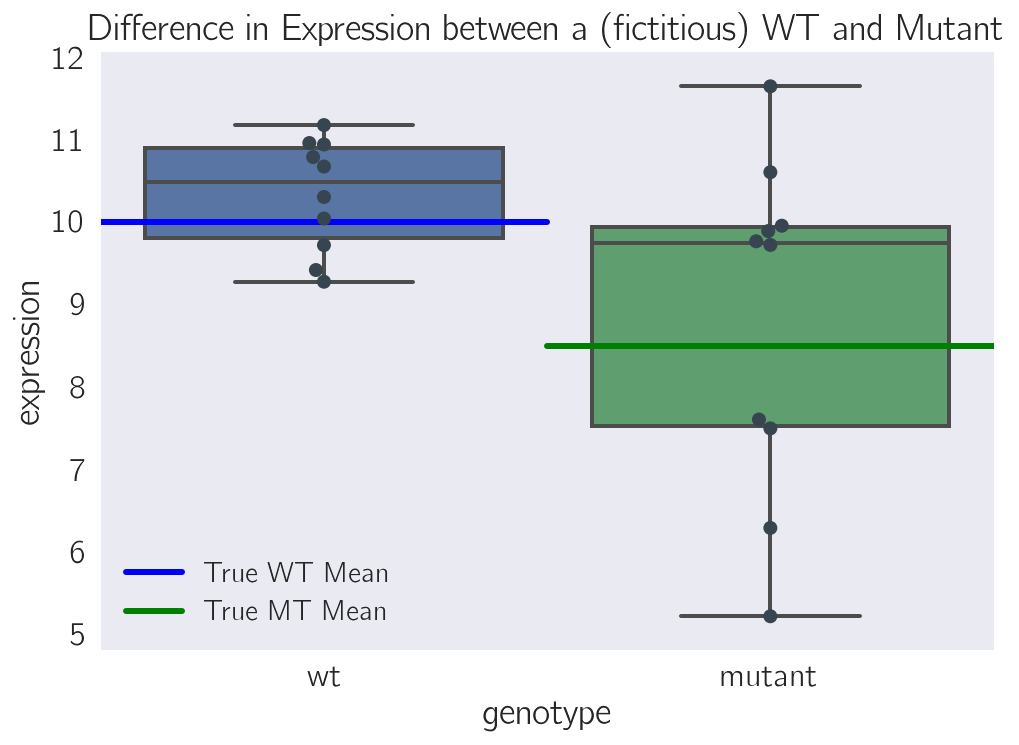

In [4]:
sns.boxplot(x='genotype', y='expression', data=tidy)
sns.swarmplot(x='genotype', y='expression', data=tidy, size=7, color='#36454F')
plt.gca().axhline(10, xmin=0, xmax=0.5, color='blue', label='True WT Mean', lw=3)
plt.gca().axhline(8.5, xmin=0.5, xmax=1, color='green', label='True MT Mean', lw=3)
plt.legend()
plt.title('Difference in Expression between a (fictitious) WT and Mutant')

# Applying a Welch t-test to the data

Next, we can do what any reasonable biologist would do. We will apply a Welch t-test. The Welch t-test is a t-test when the sample don't have equal variance, but both are normally distributed. If a t-test is to be performed, there is simply no reason to not use a Welch test (when variances are equal, it reduces to the standard Student t-test). 

In theory, this t-test will give us a p-value that will tell us whether these two samples are coming from distributions with different means or not.

In other words, the null hypothesis is:
$$
H_0: \mu_{wt} = \mu_{mt}
$$

The alternative hypothesis is:
$$
H_a: \mu_{wt} \neq \mu_{mt}
$$

We call the t-test by calling `scipy.stats.ttest_ind` and providing the wild-type data, the mutant data and setting `equal_var` to false to ensure that it is a Welch test.

In [5]:
scipy.stats.ttest_ind(tidy[tidy.genotype == 'wt'].expression.values,
                      tidy[tidy.genotype == 'mutant'].expression.values,
                      equal_var=False)

Ttest_indResult(statistic=2.2073647322385099, pvalue=0.049501266827491237)

# The Parametric Bootstrap

Ok! At this point, maybe we would be happy with a result, or we would return to the work mill for more samples to retest. However, at this point, it may be a good idea to introduce the bootstrap.

The following question motivates the boostrap: How large is the difference between the mutant and the wild-type samples? Clearly not so large enough that some points (the outliers) overlap. Perhaps it would be good to know what would happen if we repeated the experiment again. How often would we reach the same conclusion? 

In this case, we can resort to the **parametric bootstrap**.

Simply put, the parametric bootstrap enables us to model the distribution that each sample came from by assuming they follow a well-defined (analytical) distribution with parameters given by the data themselves. For example, if we assumed the data are normally distributed, we would assume that the wild-type data are coming from a distribution normal distribution with a mean equal to the mean given by the data, and standard deviation equal to the standard deviation of the data. In other words, each wild-type datum is drawn from:

$$
y_{wt, i} = \mathcal{N}(\bar{y}_wt, \sigma_{wt}).
$$

If we make this assumption, one of the things we can do is simulate that we are picking the samples over and over again (NOTE: an important point is that the simulation must pick *exactly* the same number of points as the experiment did for it to work). This is useful because it means that we can repeat the experiment many times, and ask how certain statistics about our samples behave on average if our sample is representative of the underlying biological process. 

For example, using this bootstrap, we could calculate confidence intervals for the mean by just picking 15 numbers over and over again and asking what values contain 95% of the distribution. 

Another thing we could is ask what fraction of the time we would observe a p-value as small or smaller than 0.05. This is useful if you want to know whether your study is under-powered for a specific claim. 

Next, we define the parametric bootstrap. The function below takes the wild-type and mutant data, a function `f` that will be used to calculate the statistic of interest, a number nsim which reflects the numbers of simulations to be performed and `\*\*kwargs`, extra arguments that the function `f` may or may not need. 

In [6]:
def parametric_bootstrap_test_stats(x, y, f, nsim=1000, **kwargs):
    """
    Performs a parametric bootstrap on a function `f` of the data.
    
    Params:
    x, y - data (numpy arrays)
    f - test function to calculate
    nsim - number of simulations to run
    
    Outputs:
    statistic - a numpy array of the bootstrapped function.
    """
    statistic = np.zeros(nsim)
    for i in range(nsim):
        # simulate x
        X = np.random.normal(x.mean(), x.std(), len(x))
        # simulate y
        Y = np.random.normal(y.mean(), y.std(), len(y))
        
        statistic[i] = f(X, Y, **kwargs)[1]
    
    return statistic

We will bootstrap the Welch t-test, passing as `**kwargs` the `equal_var=False` that `scipy.stats.ttest_ind` needs to ensure the test is a Welch test. 

In [7]:
pvals = parametric_bootstrap_test_stats(tidy[tidy.genotype == 'wt'].expression.values,
                                        tidy[tidy.genotype == 'wt'].expression.values,
                                        scipy.stats.ttest_ind, equal_var=False)

It takes just a second to do 1000 of these iterations. Next, we can plot the results and ask what fraction of the time we would see a value less than 0.05

Fraction of the time the p-value was less than 0.05: 0.046


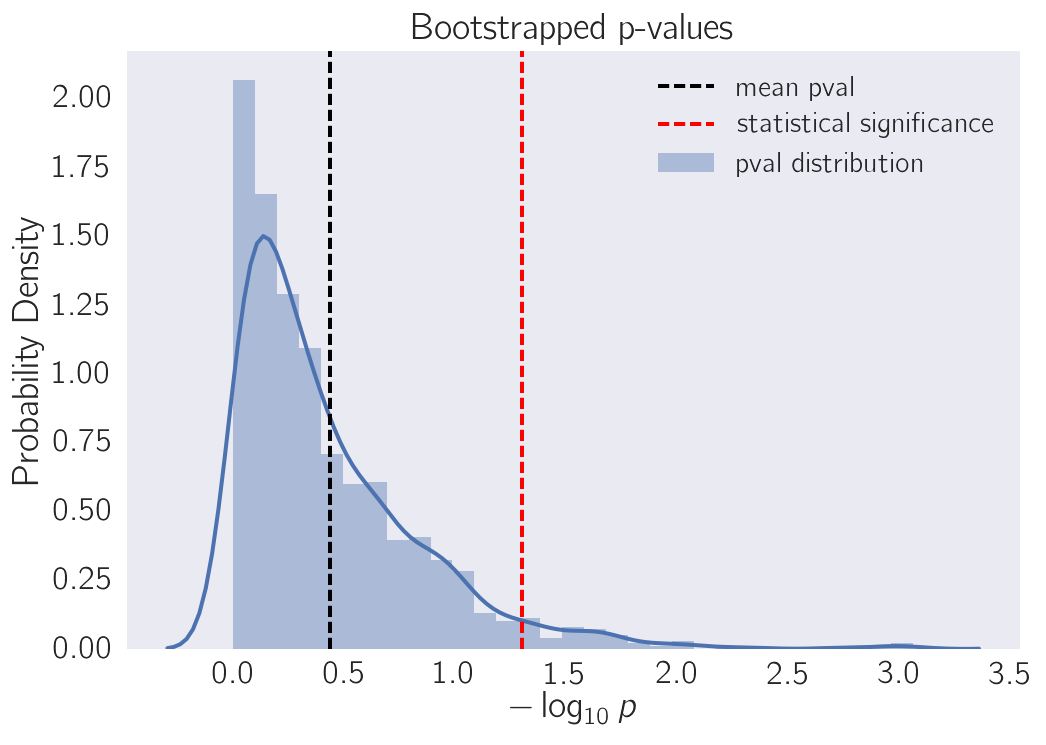

In [8]:
logp = -np.log(pvals)/np.log(10)

sns.distplot(logp, label='pval distribution')
plt.gca().axvline(logp.mean(), ls='--', color='k', label='mean pval')
plt.gca().axvline(-np.log(0.05)/np.log(10), ls='--', color='r', label='statistical significance')
plt.xlabel('$-\log_{10}{p}$')
plt.ylabel('Probability Density')
plt.title('Bootstrapped p-values')
plt.legend()

fraction = len(pvals[pvals < 0.05])/len(pvals)
print('Fraction of the time the p-value was less than 0.05: {0}'.format(fraction))

We can see that the red line, which marks the points where $p=0.05$ is almost right in the middle of the distribution. In other words, we would reject the null hypothesis only 30% of the time if we were to repeat this experiment. We need a lot more points to be able to conclude anything definitively.

What if we got more data? Let's simulate this case. We will make new data just the same as before, but this time we will take 20 points instead of 10.

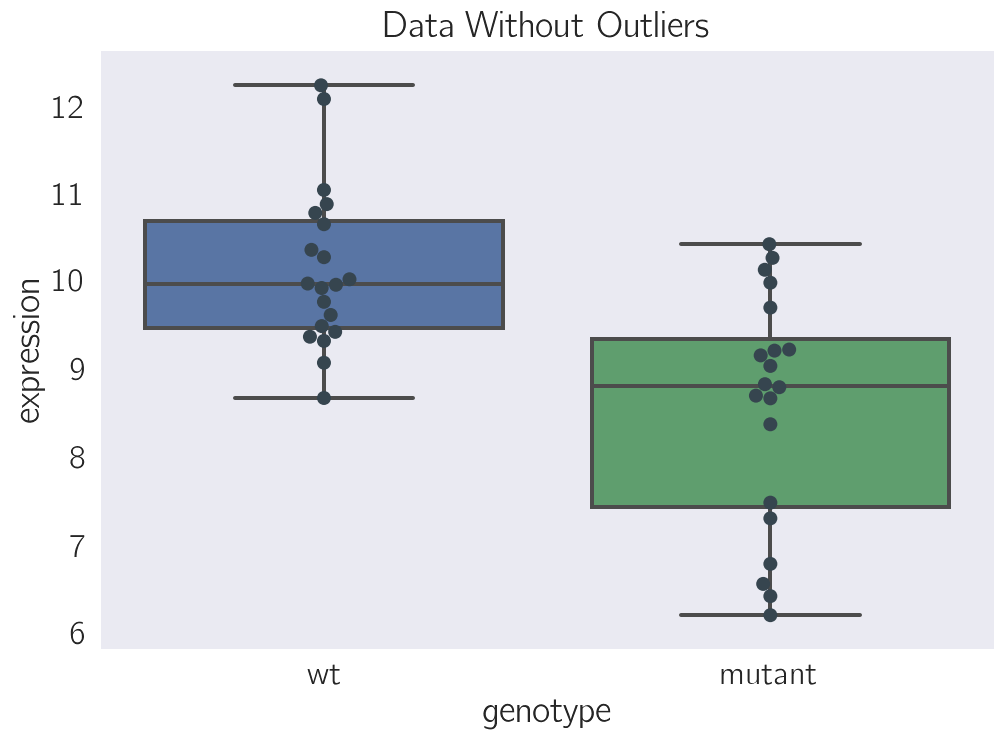

In [9]:
# generate the data:
x = np.random.normal(10, 1, 20)
y= np.random.normal(8.5, 1.5, 20)

# place the data in a dataframe
data = np.vstack([x, y]).transpose()
df = pd.DataFrame(data, columns=['wt', 'mutant'])

# tidy the dataframe, so each row is 1 observation
tidy = pd.melt(df, var_name = 'genotype', value_name='expression')
data = np.vstack([x, y]).transpose()
df = pd.DataFrame(data, columns=['wt', 'mutant'])

# tidy:
tidy = pd.melt(df, var_name = 'genotype', value_name='expression')
sns.boxplot(x='genotype', y='expression', data=tidy)
sns.swarmplot(x='genotype', y='expression', data=tidy, size=7, color='#36454F')

plt.title('Data Without Outliers')

Let's repeat the bootstrap and plot the distribution

Fraction of the time the p-value was less than 0.05: 0.992


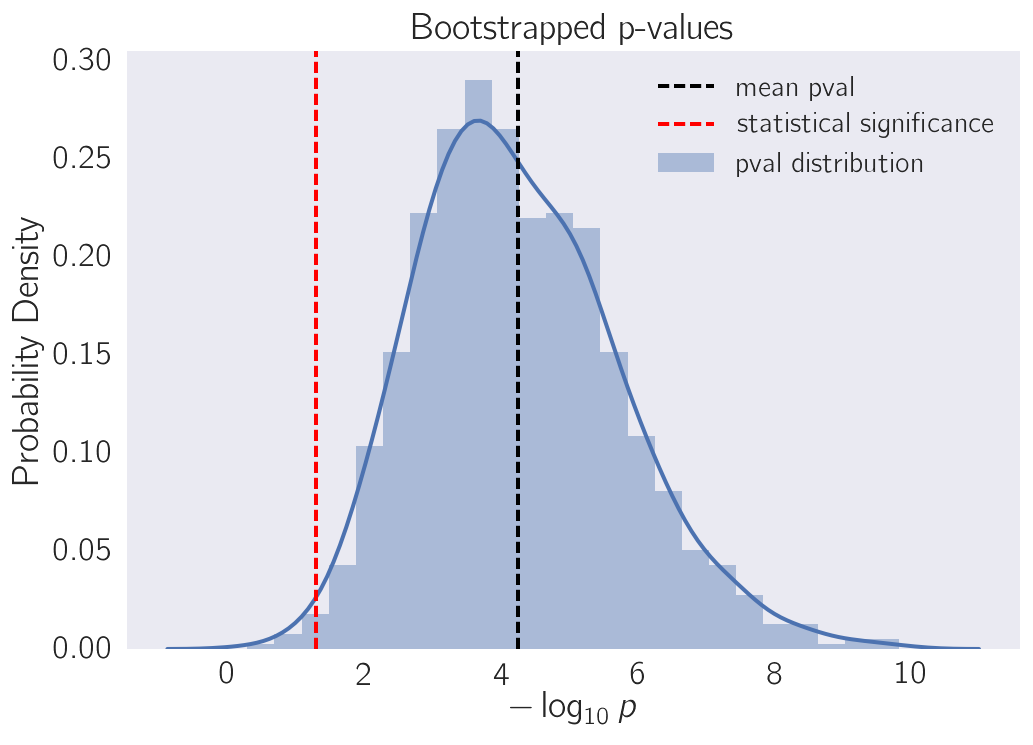

In [10]:
wt = tidy[tidy.genotype == 'wt'].expression.values
mt = tidy[tidy.genotype == 'mutant'].expression.values

pvals = parametric_bootstrap_test_stats(wt, mt, scipy.stats.ttest_ind, equal_var=False)

logp = -np.log(pvals)/np.log(10)

sns.distplot(logp, label='pval distribution')
plt.gca().axvline(logp.mean(), ls='--', color='k', label='mean pval')
plt.gca().axvline(-np.log(0.05)/np.log(10), ls='--', color='r', label='statistical significance')
plt.xlabel('$-\log_{10}{p}$')
plt.ylabel('Probability Density')
plt.title('Bootstrapped p-values')
plt.legend()


fraction = len(pvals[pvals < 0.05])/len(pvals)
print('Fraction of the time the p-value was less than 0.05: {0}'.format(fraction))

When we get more power, we can correctly reject the null hypothesis 95% of the time!